In [2]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [3]:
#### Preprocecing ###

In [4]:
jh_dir = "../../COVID-19"

In [5]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [6]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [7]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [8]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [9]:
### Data Preparation ###

In [10]:
country = 'Korea, South'
epoch = pd.to_datetime('2020-02-01')
last = pd.to_datetime('2020-04-19')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 51_845_612
iteration=10_0000
repeat = 1000

In [11]:
data = {'T': C0.shape[0], 'T0': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [12]:
### Model ###

In [59]:
sm_1 = pystan.StanModel(file="single-step.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d0d2f693a9be16fbd51f8d0cf06d787 NOW.


In [39]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49e51ece6765632a372cdde7edd52f96 NOW.


In [60]:
# Train the model and generate samples
fit_1 = sm_1.sampling(data=data, iter=iteration, init='random')
fit_1


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_6d0d2f693a9be16fbd51f8d0cf06d787.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  13.02  8.0e-3   3.59   6.98  10.45  12.69  15.23  20.95 202559    1.0
b0         0.12    0.08   0.12 7.9e-5   0.03   0.08    0.2   0.32      2  41.68
b1         0.12    0.05   0.08   0.03   0.05   0.09   0.18   0.25      2  11.23
theta_b    2.25    1.15   1.77   0.41   0.45   2.25   3.61   5.88      2    2.4
b_date    36.39    9.83  13.91  22.78  24.79  31.92  47.18  59.92      2   43.9
p          0.52    0.04   0.28   0.05   0.27   0.52   0.76   0.98     40   1.03
q0       3.7e-5  4.4e-5 6.3e-5 4.1e-7 5.8e-7 7.3e-7 7.5e-5 1.5e-4      2  44.08
q1         0.31    0.25   0.37 1.2e-3 1.7e-3   0.01   0.69   0.98      2   3.13
theta_q     0.6    0.17   0.24   0.28    0.4 

In [16]:
# Train the model and generate samples
#fit_start_2 = sm_2.sampling(data=data, iter=iteration, init='random')
#fit_start_2

In [42]:
# Train the model and generate samples
fit_const = sm_const.sampling(data=data, iter=iteration, init='random')
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_49e51ece6765632a372cdde7edd52f96.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     12.33  5.3e-3   1.98   8.81  10.94  12.21  13.59  16.53 141047    1.0
p           2.1e-7 1.4e-11 4.7e-9 2.0e-7 2.1e-7 2.1e-7 2.1e-7 2.2e-7 105684    1.0
b             0.07  2.6e-6 9.7e-4   0.07   0.07   0.07   0.07   0.07 137858    1.0
a             0.03  7.5e-7 3.5e-4   0.03   0.03   0.03   0.03   0.03 216166    1.0
d           9.1e-4  1.3e-7 5.9e-5 8.0e-4 8.7e-4 9.1e-4 9.5e-4 1.0e-3 218679    1.0
q           2.1e-4  4.4e-9 2.0e-6 2.1e-4 2.1e-4 2.1e-4 2.1e-4 2.1e-4 213048    1.0
NI[1]         9.46  3.7e-3   1.38   6.98   8.49   9.38  10.34  12.35 141986    1.0
NI[2]        16.41  6.1e-3   2.29  12.27  14.81  16.29  17.88   21.2 142484    1.0
NI[3]        28.47

In [18]:
# Save models

In [19]:
## Saving results

In [43]:
import pickle
with open("sm1_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm_1, 'fit' : fit_1}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# import pickle
# with open("sm2_fit.pkl", "wb") as f:
#     pickle.dump({'model' : sm_2, 'fit' : fit_start_2}, f, protocol=-1)
#     # or with a list
#     # pickle.dump([model, fit], f, protocol=-1)

In [44]:
import pickle
with open("sm_const_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
### Load modesl

In [24]:
with open("sm1_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_1 = data_dict['model']
fit_1 = data_dict['fit']
# fit = data_list[1]

In [25]:
# with open("sm2_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# sm_2 = data_dict['model']
# fit_start_2 = data_dict['fit']
# # fit = data_list[1]

In [26]:
with open("sm_const_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [27]:
### Convergence

In [61]:
data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_1 = az.from_pystan(fit_1, log_likelihood='log_lik')
#data_2 = az.from_pystan(fit_start_2, log_likelihood='log_lik')
#data_fixed_q = az.from_pystan(fit_fixed_q, log_likelihood='log_lik')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc28b239750>,
      dtype=object)

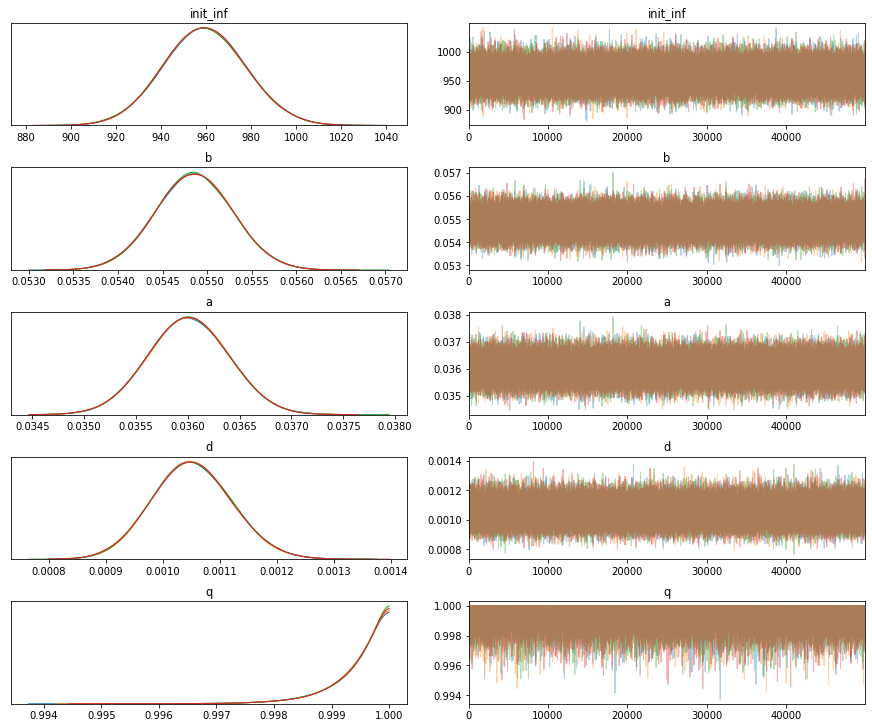

In [29]:
az.plot_trace(data_const, var_names=['init_inf', 'b', 'a', 'd', 'q'])

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0160a1b10>,
      dtype=object)

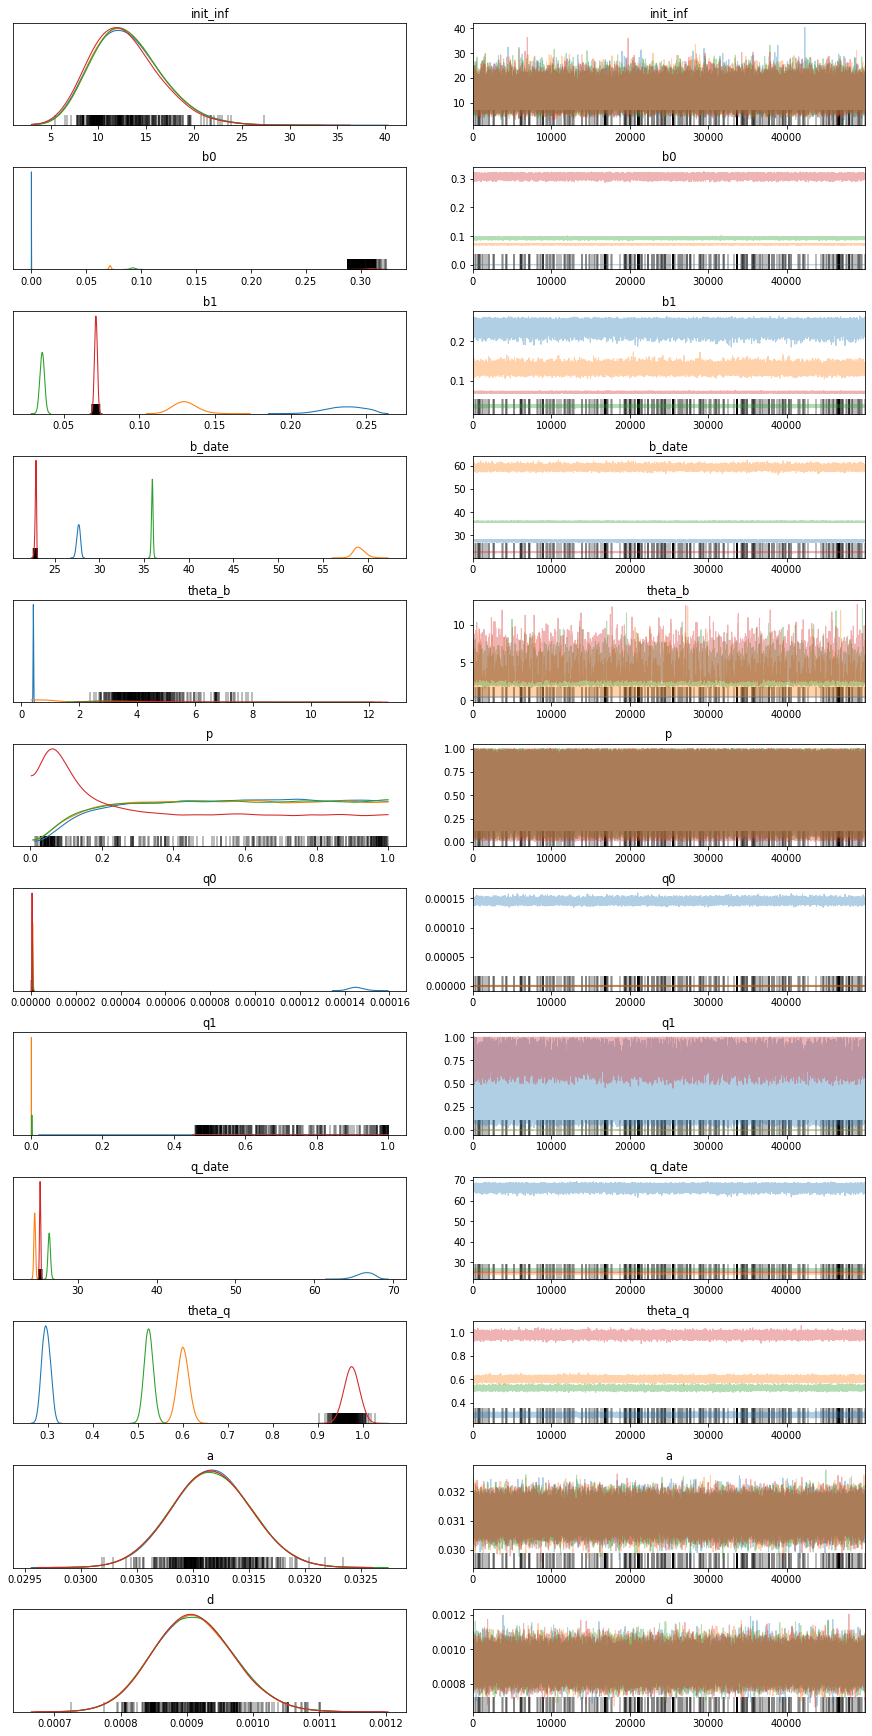

In [62]:
az.plot_trace(data_1, var_names=['init_inf', 'b0', 'b1', 'b_date', 'theta_b', 'p', 'q0', 'q1', 'q_date', 'theta_q', 'a', 'd'])

In [31]:
# az.plot_trace(data_2, var_names=['init_inf', 'b0', 'b1', 'b2', 'b_date', 'b2_date', 'theta_b', 'theta_b2', 
#                                  'q0', 'q1', 'q2', 'q_date', 'q2_date', 'theta_q', 'theta_q2', 'a', 'd'])

In [32]:
## Validation by simulation

In [33]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [34]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date,
             a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [0]
    q = q0 + (q1 - q0) * sigmoid(0, theta_q, q_date)
    S0 = [scipy.stats.poisson.rvs(q*init_inf)]
    R0 = [scipy.stats.poisson.rvs(a * S0[0])]
    D0 = [scipy.stats.poisson.rvs(d * S0[0])]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q0 + (q1 - q0) * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        NI0 = scipy.stats.poisson.rvs(q*I)
        NR0 = scipy.stats.poisson.rvs(a * (S0[-1] - R0[-1] - D0[-1]))
        ND0 = scipy.stats.poisson.rvs(d * (S0[-1] - R0[-1] - D0[-1]))
        S0.append(S0[-1]+NI0)
        R0.append(R0[-1]+NR0)
        D0.append(D0[-1]+ND0)
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0),
                        'D0':np.array(D0)},
                        index=pd.date_range(start=epoch, periods=horizon+1, freq='D'))
    return data

In [35]:
i = 1
fit = fit_start_1
horizon=(pd.to_datetime('2020-04-18') - pd.to_datetime('2020-02-01')).days
df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
df['S0']

2020-02-01        2
2020-02-02        2
2020-02-03        2
2020-02-04        4
2020-02-05        6
              ...  
2020-04-14    14099
2020-04-15    14162
2020-04-16    14234
2020-04-17    14301
2020-04-18    14366
Freq: D, Name: S0, Length: 78, dtype: int64

In [36]:
C0S = df['S0'].values
R0S = df['R0'].values
D0S = df['D0'].values
data_simulated = {'T': C0S.shape[0], 'T0': C0S.shape[0], 'P': P, 'C0': C0S, 'R0': R0S, 'D0':D0S}

In [37]:
# Train the model and generate samples
fit_simulated = sm_1.sampling(data=data_simulated, iter=iteration, init=0)
fit_simulated


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_67e149eb54c2c2426a7591e2f8f0d0c0.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   3.52  4.2e-3   1.07   1.95   2.76   3.35   4.08    6.1  65742    1.0
b0         0.38  2.4e-5 7.4e-3   0.36   0.37   0.38   0.38   0.39  94955    1.0
b1       7.3e-3  3.9e-6 1.0e-3 5.3e-3 6.6e-3 7.3e-3 8.0e-3 9.2e-3  67227    1.0
theta_b     0.7  1.4e-4   0.04   0.63   0.68    0.7   0.73   0.78  71551    1.0
b_date    31.41  2.9e-4   0.09  31.22  31.35  31.41  31.48  31.59 102275    1.0
q0         0.23  2.0e-4   0.05   0.13    0.2   0.23   0.27   0.34  68942    1.0
q1         0.83  4.3e-4   0.13   0.51   0.75   0.86   0.94   0.99  96754    1.0
theta_q     2.6  2.0e-3   0.57   1.81   2.22    2.5   2.86   3.99  79166    1.0
q_date    34.51  3.9e-4   0.11  34.29  34.43 

In [38]:
(fit_start_1['init_inf'][i], fit_start_1['b0'][i], fit_start_1['b1'][i], fit_start_1['theta_b'][i], 
fit_start_1['b_date'][i], fit_start_1['q0'][i], fit_start_1['q1'][i], fit_start_1['theta_q'][i], fit_start_1['q_date'][7]
,fit_start_1['a'][i], fit_start_1['d'][i])

(3.2149255975303017,
 0.3766929083968401,
 0.006372147624703675,
 0.7153477960426099,
 30.460747660939536,
 0.23441587677309728,
 0.9645773007490563,
 2.3235648060262,
 33.75479851511373,
 0.03177674452405388,
 0.0009408349841255603)

In [39]:
### Visualization ###

In [40]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    D0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        i = np.random.randint(n)
        try:
            q0 = fit['q0'][i]
        except:
            q0 = 0
        
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=q0,
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        D0 = pd.concat([D0, df['D0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0, D0
    

In [41]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [42]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-18')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [43]:
S, R, D, b, q, S0S, R0S, I0S, D0S = monte_carlo(fit_start_1, 120)

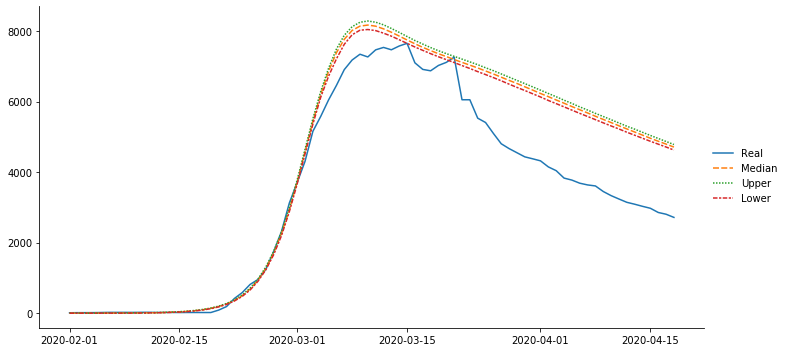

In [44]:
draw(I0S, real=(confirmed-recovered)[country])

In [45]:
S.median(axis=1)[pd.to_datetime('2020-04-18')]

198537.87568493147

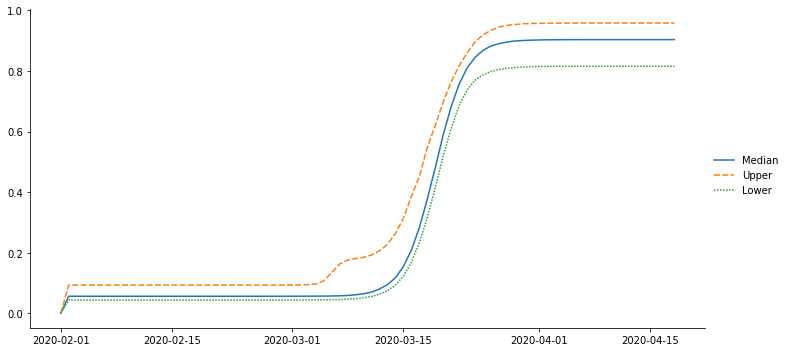

In [46]:
draw(q)

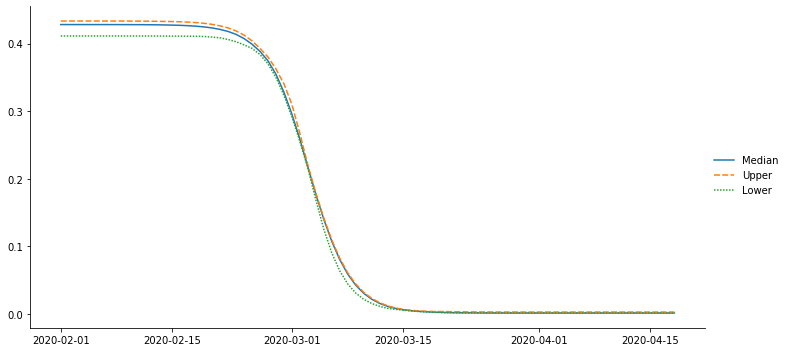

In [47]:
draw(b)

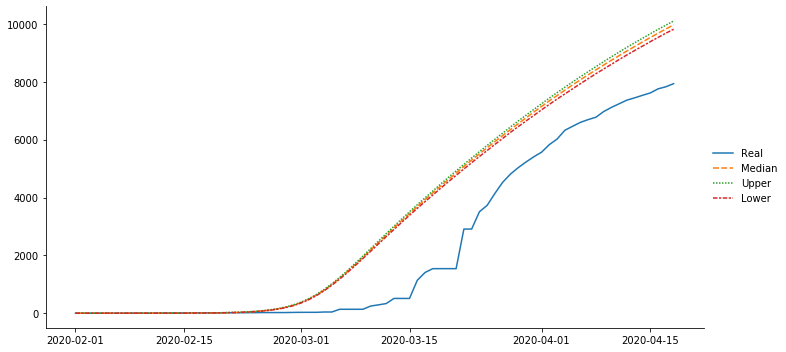

In [48]:
draw(R0S, real=recovered[country])

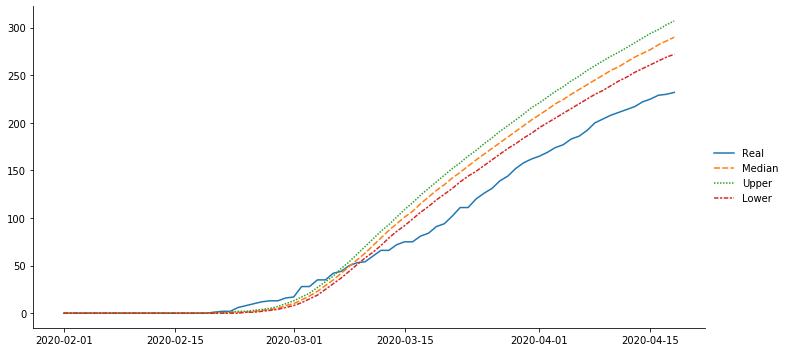

In [49]:
draw(D0S, real=death[country])

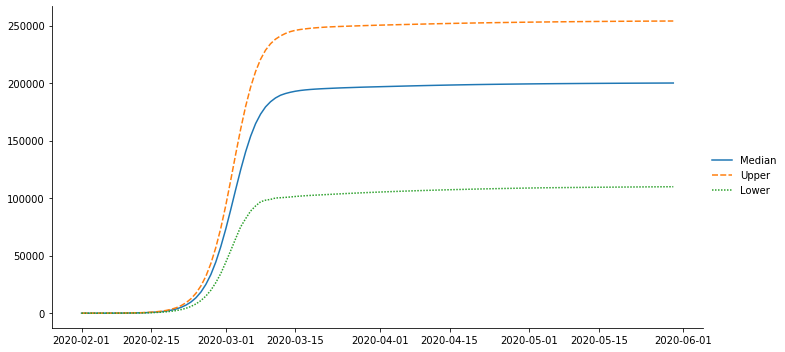

In [50]:
draw(S, upto=pd.to_datetime('2020-05-30'))

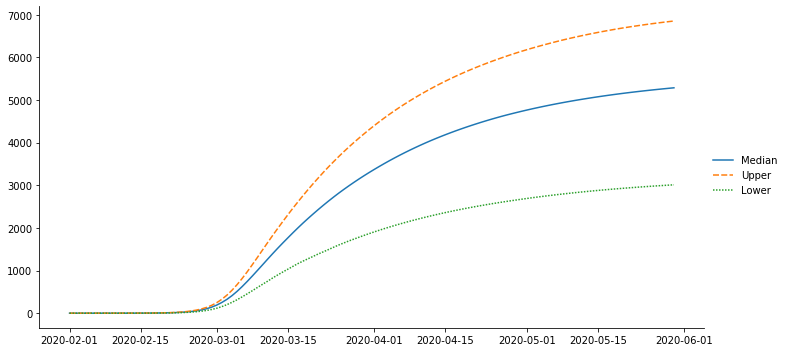

In [51]:
draw(D, upto=pd.to_datetime('2020-05-30'))

In [52]:
### model selection

In [53]:
az.loo(data_const)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 200000 by 78 log-likelihood matrix

       Estimate       SE
IC_loo 19795.98  3929.03
p_loo    334.98        -

There has been a warning during the calculation. Please check the results.

In [54]:
az.loo(data_1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:759: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 

Computed from 200000 by 78 log-likelihood matrix

       Estimate       SE
IC_loo 25298962.35  5443508.08
p_loo  12374796.30        -

There has been a warning during the calculation. Please check the results.

In [55]:
az.compare({'const':data_const, '1-step':data_1})

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
const,0,19871.2,372.609,0,1,4004.21,0,True,deviance
1-step,1,3.28429e+11,1.64214e+11,3.28429e+11,0,9.38356e+10,9.22484e+10,True,deviance


In [56]:
az.loo(data_1, pointwise=True)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:759: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 

Computed from 200000 by 78 log-likelihood matrix

       Estimate       SE
IC_loo 25298962.35  5443508.08
p_loo  12374796.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)   78  100.0%

In [57]:
az.loo(data_const, pointwise=True)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 200000 by 78 log-likelihood matrix

       Estimate       SE
IC_loo 19795.98  3929.03
p_loo    334.98        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       57   73.1%
 (0.5, 0.7]   (ok)          7    9.0%
   (0.7, 1]   (bad)         6    7.7%
   (1, Inf)   (very bad)    8   10.3%

In [58]:
data_CV = {'T': C0.shape[0], 'T0': 50, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [59]:
# Train the model and generate samples
fit_1_CV = sm_1.sampling(data=data_CV, iter=iteration, init=0)


In [60]:
v_log_lik = fit_1_CV['v_log_lik']
v_log_lik[~np.isnan(v_log_lik)].mean()

-280326.9241803248

In [61]:
# Train the model and generate samples
fit_const_CV = sm_const.sampling(data=data_CV, iter=iteration, init=0)
fit_const_CV['v_log_lik'].mean()

-33370.74993009398

In [62]:
fit_1_CV


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_67e149eb54c2c2426a7591e2f8f0d0c0.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   1.03    0.07   0.53   0.51   0.67   0.84    1.2   2.46     56   1.09
b0         0.38  1.2e-4 6.5e-3   0.36   0.37   0.38   0.38   0.39   2765    1.0
b1         0.03  1.1e-4 3.7e-3   0.02   0.03   0.03   0.03   0.04   1112   1.01
theta_b    0.47  1.1e-3   0.02   0.43   0.45   0.47   0.48   0.52    412   1.01
b_date    30.04  1.0e-3   0.04   30.0  30.01  30.03  30.06  30.14   1423    1.0
q0         0.66    0.03   0.23   0.23   0.48   0.69   0.85   0.98     67   1.08
q1          0.3    0.01   0.11    0.1   0.21    0.3   0.38   0.49     88   1.06
theta_q    3.28    0.02   0.79    2.2   2.75   3.14   3.62   5.31   1080    1.0
q_date    36.38    0.01   0.18  36.06  36.26 

In [63]:
fit_const_CV


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_2b05eb424e3c120ec36ee20fff28dcc2.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    377.35    0.03  10.74 356.63 370.02 377.24 384.51 398.68 127109    1.0
b             0.07  1.9e-6 6.7e-4   0.07   0.07   0.07   0.07   0.08 118870    1.0
a             0.01  6.7e-7 2.9e-4   0.01   0.01   0.01   0.01   0.01 187686    1.0
d           7.7e-4  1.7e-7 7.6e-5 6.3e-4 7.2e-4 7.7e-4 8.2e-4 9.3e-4 203693    1.0
q              1.0  2.8e-6 1.3e-3    1.0    1.0    1.0    1.0    1.0 224128    1.0
NI[1]        27.93  1.6e-3   0.59  26.79  27.53  27.93  28.33  29.09 138694    1.0
NI[2]        29.66  1.6e-3   0.61  28.47  29.24  29.65  30.06  30.85 139274    1.0
NI[3]        31.48  1.7e-3   0.63  30.26  31.06  31.48  31.91  32.73 139911    1.0
NI[4]        33.43